In [ ]:
#load GMM
import numpy as np
import cv2
import glob
import pandas as pd
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import mixture
import itertools
from sklearn.neighbors import KDTree
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot, iplot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
joints = [[0, 1], [2, 3], [3, 4], [5, 6], [6, 7], [8, 9], [9, 10], [11, 12], [12, 13], [1,2, 8, 11, 5,1]]
#joints = np.array([[0,1],[0,2],[0,3],[1,4],[2,5],[3,6],[4,7],[5,8],[6,9],[7,10],[8,11],[9,12],[9,13],
          #[9,14],[12,15],[13,16],[14,17],[16,18],[17,19],[18,20],[19,21],[20,22],[21,23]])

In [ ]:
def plot_kp(kp, name):
    plt.rcParams["figure.figsize"] = (6.65,5)

    row = kp.reshape(2,14)
    xs,ys = row[0,:], row[1,:]
    fig = plt.figure()
    for j in joints:
      plt.plot(np.take(xs, j),np.take(ys, j), color="black", marker="o")
    plt.xlim([0, 320])
    plt.ylim([240, 0])
    #plt.savefig(str(name), transparent=True)
    #plt.show()

def bbox2cnt(df):
    dfn = pd.DataFrame()
    dfn['x_cnt'] = df['xmin'] + (df['xmax'] - df['xmin'])/2
    dfn['y_cnt'] = df['ymin'] + (df['ymax'] - df['ymin'])/2
    return dfn

def kp2bbox(kp):
    ar = np.array(kp)
    dfn = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax'])
    dfn["xmin"] = np.min(ar[:,:14], axis=1)
    dfn["ymin"] = np.min(ar[:,14:28], axis=1)
    dfn["xmax"] = np.max(ar[:,:14], axis=1)
    dfn["ymax"] = np.max(ar[:,14:28], axis=1)
    return dfn

def n_clusters(X,seed=42):
    maximum = 300
    step = 50
    n_components = np.arange(1, maximum, step)
    models = [mixture.GaussianMixture(n, covariance_type='full', random_state=seed) for n in n_components]
    aics = [model.fit(X).aic(X) for model in models]
    plt.plot(n_components, aics)
    plt.show()
    #plt.savefig(path)
    return n_components[np.argmin(aics)]

def plot_pairs(d, set1, set2):
  for i in range(len(d)):
    fig, ax = plt.subplots(1,2, figsize=(7,3.5))

    row1 = set1[i].reshape(2,14)
    for j in joints:
      ax[0].plot(np.take(row1[0,:], j),np.take(row1[1,:], j),marker="o", color="black")
    #ax[0].imshow(np.ones((240,240))*1, cmap='gray')
    #title = "pair:" + str(i) +  ", "+ "Eucl d:" + str(np.round(d[i], 3))
    ax[0].title.set_text('Pose 0')
    ax[0].set_xlim([0, 240])
    ax[0].set_ylim([240, 0])

    row2 = set2[i].reshape(2,14)
    for j in joints:
      ax[1].plot(np.take(row2[0,:], j),np.take(row2[1,:], j),marker="o", color="black")
    #ax[1].imshow(np.ones((240,240))*1, cmap='gray')
    ax[1].title.set_text('Pose' + str(i) )
    ax[1].set_xlim([0, 240])
    ax[1].set_ylim([240, 0])
  
    title = "Similarity Score:" + str(np.round(d[i], 2))
    plt.suptitle(title, y=1.1, fontsize=13)


    fig.tight_layout()
    plt.show()

    #plt.savefig('/content/' + str(i) + ".jpg", transparent=False)

def cosine_sim(kp):
  sim = (1- np.abs(cosine_similarity(kp)))
  sim[sim<1e-4] = 0
  sim = np.round(np.sqrt(sim),3)
  return sim

def stats(sim, thresh):
  mean = np.round(np.mean(sim), 3)
  std = np.round(np.std(sim), 3)
  n_occ = np.sum(sim<thresh, axis=1)
  ds = np.mean(sim, axis=0)
  print(mean, std, np.mean(n_occ))
  return n_occ

def filter(kp, n_occ):
  kp_fil = kp[np.argsort(n_occ)][:3000]
  kp_fil = kp_fil[np.random.choice(3000, 3000, replace=False)][:1000]
  return kp_fil


def plot_heatmap(sim_matrix):
  plt.rcParams["figure.figsize"] = (5,5)
  plt.imshow(sim_matrix, cmap='plasma')
  plt.xlabel('Pose Number')
  plt.ylabel('Pose Number')
  cax = plt.axes([1, 0.1, 0.075, 0.8])
  plt.colorbar(cax=cax)

  plt.show()
  #tick = np.linspace(0, 1000, 6)
  #ax = sns.heatmap(sim_matrix, vmin=0, vmax=1, annot=True, cmap="viridis", yticklabels=tick,  xticklabels=tick)

def create_pairs(src_names, n_tgt):
    names = list(map(str, range(n_tgt)))
    df = pd.DataFrame(columns=['names_src','names_tgt'])
    df['names_src'] = pd.concat([src_names]*4)
    df['names_tgt'] =  names
    df = df.reset_index(drop=True)  
    return df

def clip(dfn, xmax, ymax):
    #[-4, 4,-5,7]
    dfn["xmin"] =  (dfn["xmin"].to_numpy()).clip(min=0) 
    dfn["xmax"] =  (dfn["xmax"].to_numpy()).clip(max=xmax)
    dfn["ymin"] =  (dfn["ymin"].to_numpy()).clip(min=0) 
    dfn["ymax"] =  (dfn["ymax"].to_numpy()).clip(max=ymax) 
    return dfn

def plot_hist(n_occ, bins):
  plt.rcParams["figure.figsize"] = (5,5)
  n, bins, patches = plt.hist(n_occ, bins=bins)
  plt.xlabel('Number of Neighbours')
  plt.ylabel('Number of points')
  plt.title('Histogram of Neighbours')
  #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
  #plt.xlim(40, 160)
  #plt.ylim(0, 0.03)
  plt.grid(True)
  plt.show()

In [ ]:
#1000 source keypoints loading and normalizing 
kp = pd.read_csv('/content/drive/MyDrive/surreal/play/1000_open/kp/kp_src.csv')
src_names = kp["names"]

In [ ]:
kp = (kp.drop(columns=['names'])).to_numpy()
bbox = kp2bbox(kp)
df_cnt = bbox2cnt(bbox)

#Centre vectors
xcnt = df_cnt['x_cnt'].to_numpy()
ycnt = df_cnt['y_cnt'].to_numpy()
kp_src = np.zeros((kp.shape[0],kp.shape[1]))
kp_src[:, :14] = np.subtract(kp[:, :14], xcnt.reshape(-1,1))
kp_src[:, 14:28] = np.subtract(kp[:, 14:28], ycnt.reshape(-1,1))



0.49 0.313 1.4


Text(67.5, 0.5, 'Pose Number')

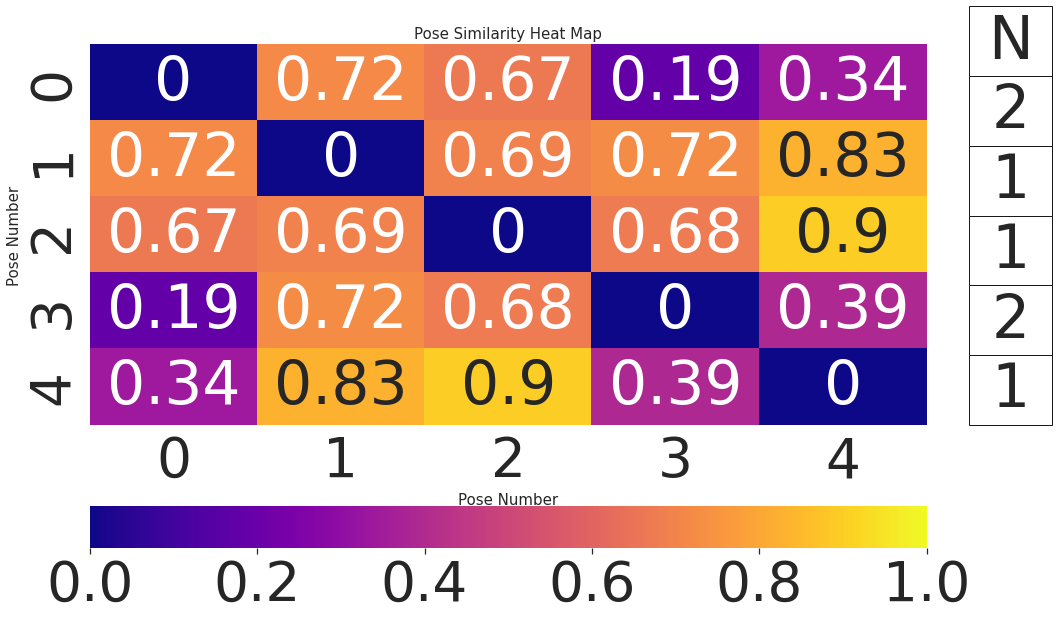

In [ ]:
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_adjust.html#sphx-glr-gallery-subplots-axes-and-figures-subplots-adjust-py

plt.rcParams["figure.figsize"] = (15,10)
thresh =0.3
n_plot = 5
s_indx = 194
sim_matrix_src_sample = cosine_sim(kp_src[s_indx:s_indx+n_plot])
occ = stats(sim_matrix_src_sample, thresh)
df_occ = pd.DataFrame({"Neighbours": occ}, dtype=str)

plt.table(cellText=df_occ['Neighbours'],colLabels=df_occ.columns[0], 
         loc='right', bbox = [1.05, 0, 0.1, 1.1], cellLoc='center')


sns.heatmap(sim_matrix_src_sample, vmin=0, vmax=1, annot=True, cmap='plasma', cbar_kws={"orientation": "horizontal"})
#sns.set(font_scale=1)
plt.title('Pose Similarity Heat Map', fontsize=15)
plt.xlabel('Pose Number', fontsize=15)
plt.ylabel('Pose Number', fontsize=15)

In [ ]:
#plot_hist(df_occ['Neighbours'], bins=10)

In [ ]:
set1_ip_s = np.tile(kp_src[s_indx], (n_plot,1))
set2_ip_s = kp_src[s_indx:s_indx+n_plot] 
ds = sim_matrix_src_sample[0] 
plot_pairs(ds, set1_ip_s, set2_ip_s)

NameError: ignored

In [ ]:
df = pd.DataFrame(kp_src)
X = df

fig = go.Figure()

#plotting PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)

df_kp_src = pd.DataFrame({"x":components[:,0], "y":components[:,1], "Method": ["Source Poses"]*len(components)})
fig.add_trace(go.Scatter(x=df_kp_src["x"], y=df_kp_src["y"], mode='markers', name="Source Poses", opacity=0.3))
fig.update_layout(xaxis_title="PC1(Expl Var 32%)", yaxis_title="PC2(Expl Var 22%)")

for i in range(1,n_plot):
  list_x = [components[s_indx,0], components[s_indx+i,0]]
  list_y = [components[s_indx,1], components[s_indx+i,1]]
  list_p = ['P0', 'P1', 'P2','P3', 'P4']
  fig.add_trace(go.Scatter(x = list_x, y = list_y,
                           mode='lines',line_width=5, name="Sim Score: " + str(np.round(ds[i],2)), text=list_p ))

fig.show()
print(pca.explained_variance_ratio_)



[0.32132163 0.21615432]


In [ ]:
df = pd.DataFrame(kp_src)
X = df

fig = go.Figure()

#plotting PCA
pca = PCA(n_components=3)
components = pca.fit_transform(X)

df_kp_src = pd.DataFrame({"x":components[:,0], "y":components[:,1], "z":components[:,2],
                          "Method": ["Source Poses"]*len(components)})
fig.add_trace(go.Scatter3d(x=df_kp_src["x"], y=df_kp_src["y"], z=df_kp_src["z"],
                         mode='markers', name="Source Poses", marker=dict(size=5)))

for i in range(1,n_plot):
  list_x = [components[s_indx,0], components[s_indx+i,0]]
  list_y = [components[s_indx,1], components[s_indx+i,1]]
  list_z = [components[s_indx,2], components[s_indx+i,2]]

  fig.add_trace(go.Scatter3d(x = list_x, y = list_y, z=list_z,
                           mode='lines',line_width=5, name="Sim Score: " + str(np.round(ds[i],2))))
fig.update_layout(scene = dict(
                    xaxis_title="PC1(Expl Var 32%)",
                    yaxis_title="PC2(Expl Var 22%)",
                    zaxis_title="PC3(Expl Var 16%)"))
fig.show()
print(pca.explained_variance_ratio_)


[0.32132163 0.21615432 0.15953727]


0.43 0.21 288.436


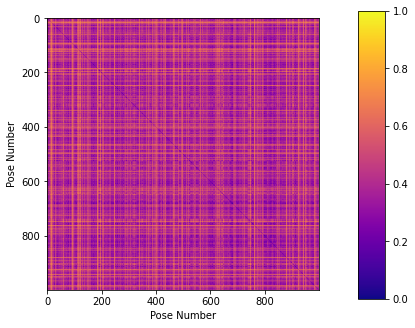

In [ ]:
thresh = 0.3
sim_matrix_src = cosine_sim(kp_src)
n_occ_src = stats(sim_matrix_src, thresh)
plot_heatmap(sim_matrix_src)


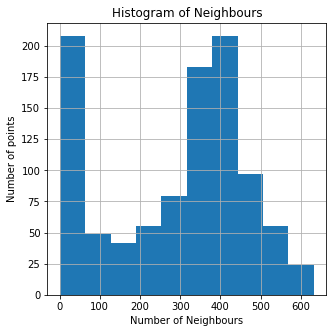

In [ ]:
plot_hist(n_occ_src, bins=10)

In [ ]:
kp_src_fil = kp_src[np.argsort(n_occ_src)][:250]

In [ ]:
def n_clusters(X,seed):
    plt.rcParams["figure.figsize"] = (6.65,5)
    n_components = np.arange(1, 400, 50)
    models = [mixture.GaussianMixture(n, covariance_type='full', random_state=seed) for n in n_components]
    aics = [model.fit(X).aic(X) for model in models]
    plt.plot(n_components, aics)
    plt.xlabel('Number of clusters(k)')
    plt.ylabel('AIC')

n_clusters(kp_src,1)

0.43 0.21 288.436


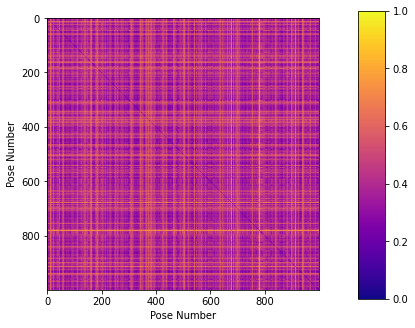

421

In [ ]:
n_find = int(1e3)
rand_ind1=np.random.choice(n_find, n_find, replace=False)
rand_ind2=np.random.choice(n_find, n_find, replace=False)
kp_intrp = 0.5*kp_src[rand_ind1] + 0.5*kp_src[rand_ind1]

thresh = 0.3
sim_matrix_intrp = cosine_sim(kp_intrp)
n_occ_src_intrp = stats(sim_matrix_intrp, thresh)
plot_heatmap(sim_matrix_intrp)

rand_ind1[0]

rand_ind2[0]

In [ ]:
"""
SOURCE OVER
GAUSSIAN NEXT
"""

'\nSOURCE OVER\nGAUSSIAN NEXT\n'

In [ ]:
gmm = mixture.GaussianMixture(n_components=100, random_state=1).fit(kp_src)

0.434 0.205 267.252


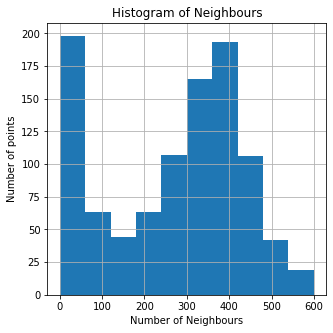

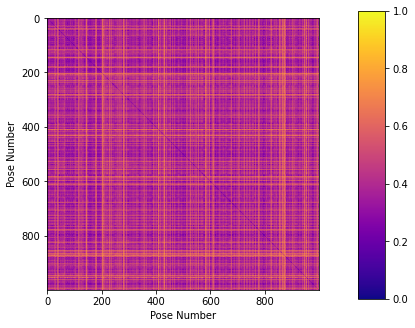

In [ ]:
#Model: Gaussian Sampling
n_find = int(1e3)
rand_ind1=np.random.choice(n_find, n_find, replace=False)
kp_gauss_1k = gmm.sample(n_find)[0][rand_ind1]

thresh = 0.3
sim_matrix_gauss = cosine_sim(kp_gauss_1k)
n_occ_gauss_1k = stats(sim_matrix_gauss, thresh)
plot_hist(n_occ_gauss_1k, bins=10)
plot_heatmap(sim_matrix_gauss)

0.437 0.211 2779.6376


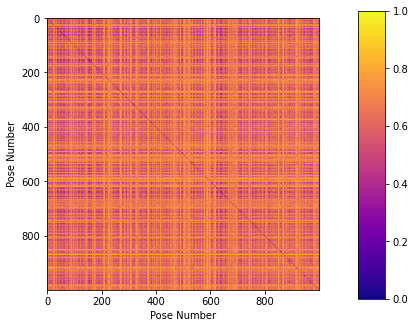

0.64 0.219 47.028


In [ ]:
#Model: Filter
n_find = int(1e4)
kp_gauss = gmm.sample(n_find)[0]

thresh = 0.3
sim_matrix_gauss = cosine_sim(kp_gauss)
n_occ_gauss = stats(sim_matrix_gauss, thresh)

kp_fil = filter(kp_gauss, n_occ_gauss)
sim_matrix_fil = cosine_sim(kp_fil)
plot_heatmap(sim_matrix_fil)
n_occ_fil = stats(sim_matrix_fil, thresh)

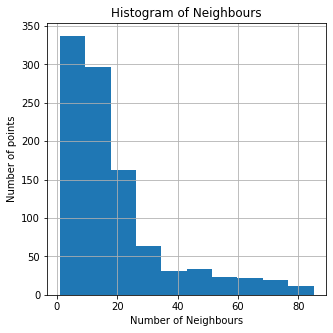

In [ ]:
plot_hist(n_occ_fil, bins=10)

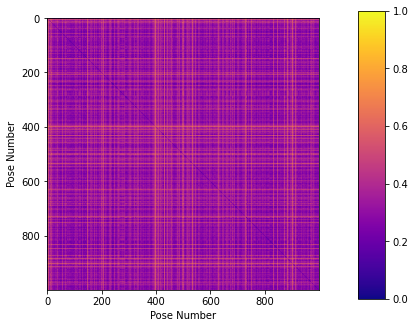

0.341 0.169 495.676


In [ ]:
#Model: Interp
n_find = int(1e4)
rand_ind1 = np.random.choice(n_find, n_find, replace=False)
rand_ind2 = np.random.choice(n_find, n_find, replace=False)
rand_ind3 = np.random.choice(n_find, n_find, replace=False)
gauss_1 = gmm.sample(n_find)[0][rand_ind1]
gauss_2 = gmm.sample(n_find)[0][rand_ind2]
samples_ip = 0.5*gauss_1 + 0.5*gauss_2
kp_ip = np.vstack((gmm.sample(n_find)[0][rand_ind3], samples_ip))

thresh = 0.3
#kp_ip_rnd = kp_ip[rand_ind1][:1000]
kp_ip_rnd = samples_ip[rand_ind1][:1000]
sim_matrix_ip = cosine_sim(kp_ip_rnd)
plot_heatmap(sim_matrix_ip)
n_occ_ip = stats(sim_matrix_ip, thresh)

In [ ]:
numb = 32
plot_kp(gauss_1[numb]+120, "hi")
plot_kp(gauss_2[numb]+120, "hi")
plot_kp(samples_ip[numb]+120, "hi")

0.395 0.196 7394.7481


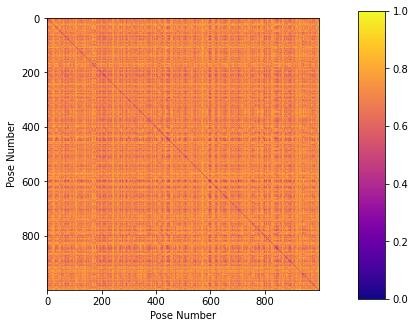

0.705 0.185 17.592


In [ ]:
#Model: Gauss sampl + Interp + Filtering
thresh = 0.3
sim_matrix_ip = cosine_sim(kp_ip)
n_occ_ip = stats(sim_matrix_ip, thresh)

kp_ip_fil = filter(kp_ip, n_occ_ip)
sim_matrix_ip_fil = cosine_sim(kp_ip_fil)
plot_heatmap(sim_matrix_ip_fil)
n_occ_ip_fil = stats(sim_matrix_ip_fil, thresh)

In [ ]:
"""for i in range(9):
  kp_ip_filn = 0.5*kp_ip_fil[np.random.choice(1000, 1000, replace=False)] + 0.5*kp_ip_fil[np.random.choice(1000, 1000, replace=False)]
  kp_ip_fil = np.vstack((kp_ip_fil, kp_ip_filn))

sim_matrix_ip_filn = cosine_sim(kp_ip_fil)
n_occ_ip_filn = stats(sim_matrix_ip_filn, thresh)

kp_ip_fil2 = filter(kp_ip_fil, n_occ_ip_filn)
sim_matrix_ip_fil2 = cosine_sim(kp_ip_fil2)
plot_heatmap(sim_matrix_ip_fil2)
n_occ_ip_fil2 = stats(sim_matrix_ip_fil2, thresh)
"""

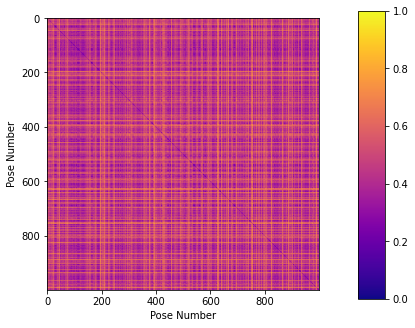

0.473 0.21 197.872


In [ ]:
#Model: Gauss Sampl + Filtered(cluster distance)

labels = gmm.predict(kp_gauss)
means = gmm.means_
df=pd.DataFrame()
df['labels'] = labels
df['clust_d'] = np.linalg.norm(kp_gauss - np.take(means, labels, axis=0), axis=1)


mean_ds = []
for i in range(len(means)):
  df_tmp = df.loc[df['labels']==i]
  mean_ds.append(np.mean(df_tmp['clust_d']))
df['mean_ds'] = np.take(mean_ds, labels, axis=0)

#Filter
df['d_scale'] = df['clust_d']/df['mean_ds']
df = df.sort_values('d_scale', ascending=False)
df = df[:3000]
df = df.sample(n = 1000, random_state = 1)
kp_gauss_fil_c = kp_gauss[np.array(df.index)]

thresh = 0.3
sim_matrix_gauss_fil_c = cosine_sim(kp_gauss_fil_c)
plot_heatmap(sim_matrix_gauss_fil_c)
n_occ_ip_fil_c = stats(sim_matrix_gauss_fil_c, thresh)


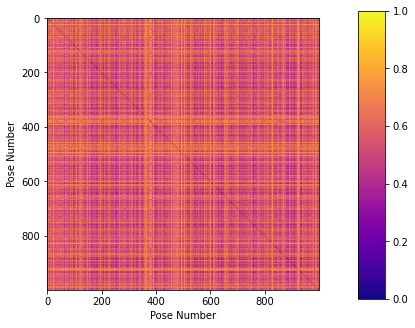

0.569 0.212 102.3


In [ ]:
#Model: Gauss Sampl + Interp + Filtered(cluster distance)

labels = gmm.predict(kp_ip)
means = gmm.means_
df=pd.DataFrame()
df['labels'] = labels
df['clust_d'] = np.linalg.norm(kp_ip - np.take(means, labels, axis=0), axis=1)


mean_ds = []
for i in range(len(means)):
  df_tmp = df.loc[df['labels']==i]
  mean_ds.append(np.mean(df_tmp['clust_d']))
df['mean_ds'] = np.take(mean_ds, labels, axis=0)

#Filter
df['d_scale'] = df['clust_d']/df['mean_ds']
df = df.sort_values('d_scale', ascending=False)
df = df[:3000]
df = df.sample(n = 1000, random_state = 1)
kp_ip_fil_c = kp_ip[np.array(df.index)]

thresh = 0.3
sim_matrix_ip_fil_c = cosine_sim(kp_ip_fil_c)
plot_heatmap(sim_matrix_ip_fil_c)
n_occ_ip_fil_c = stats(sim_matrix_ip_fil_c, thresh)

0.574 0.203 882.8244


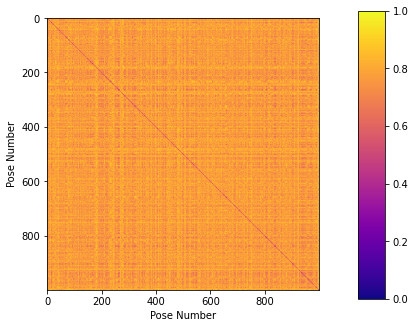

0.77 0.152 2.742


In [ ]:
#MPII
load = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/mpii_human_pose.csv', delimiter=',')
load = load[load!= -1]
load = load.dropna()
load = load.reset_index(drop=True)
load.head()

order = [9,7,12,11,10,13,14,15,2,1,0,3,4,5]
cols = list(load.columns)
col_x =  [s for s in cols if "_X" in s]
col_y =  [s for s in cols if "_Y" in s]
col_x = [col_x[i] for i in order]
col_y = [col_y[i] for i in order]
dfx = load[col_x]
dfy = load[col_y]

df_concat = pd.concat([dfx, dfy], axis=1)
kp_mpii_full = np.array(df_concat)

bbox = kp2bbox(kp_mpii_full)
df_cnt = bbox2cnt(bbox)

#Centre vectors
xcnt = df_cnt['x_cnt'].to_numpy()
ycnt = df_cnt['y_cnt'].to_numpy()
kp_mpii = np.zeros((kp_mpii_full.shape[0],kp_mpii_full.shape[1]))
kp_mpii[:, :14] = np.subtract(kp_mpii_full[:, :14], xcnt.reshape(-1,1))
kp_mpii[:, 14:28] = np.subtract(kp_mpii_full[:, 14:28], ycnt.reshape(-1,1))

Scale = np.array(load['Scale'])
kp_mpii = kp_mpii / Scale[:,None]

np.random.seed(0)
n = 10000
kp_mpii_n = kp_mpii[np.random.choice(len(kp_mpii),n, replace=False)]

thresh = 0.3
sim_matrix_mpii = cosine_sim(kp_mpii_n)
n_occ_mpii = stats(sim_matrix_mpii, thresh)

kp_mpii_fil = filter(kp_mpii_n, n_occ_mpii)
sim_matrix_mpii_fil = cosine_sim(kp_mpii_fil)
plot_heatmap(sim_matrix_mpii_fil)
n_occ_ip_fil = stats(sim_matrix_mpii_fil, thresh)



In [ ]:
dict_models = {"A      Source":kp_src, "B      Gauss sampl": kp_gauss_1k, "C       Interp": kp_intrp,
                "D      :Gauss sampl + Filt(CD)": kp_gauss_fil_c, "E       :Gauss sampl + Interp + Filt(CD)": kp_ip_fil_c,
               "F       :Gauss sampl + Filt(LN)": kp_fil, "G       :Gauss sampl + Interp + Filt(LN)": kp_ip_fil, "H       :MPII_test_set":kp_mpii_fil}

df_kp = pd.DataFrame()
df_model = pd.DataFrame()

for value, key in enumerate(dict_models.keys()):
  df_model = pd.concat([df_model, pd.DataFrame({"model" : [key]*len(dict_models[key])})], ignore_index=True)
  df_kp = pd.concat([df_kp, pd.DataFrame(dict_models[key])], ignore_index=True)
  
X = df_kp

#plotting PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)
df_kp = pd.DataFrame({"x":components[:,0], "y":components[:,1], "Method": df_model['model']})
fig = px.scatter(df_kp, x="x", y="y", color='Method')
fig.update_layout(xaxis_title="PC1 (Expl Var 32%)", yaxis_title="PC2 (Expl Var 22%)", font=dict(size=18))
fig.show()



In [ ]:
dict_models = {"Source":kp_src, "Gauss sampl": kp_gauss_1k, "Interp": kp_intrp,
                "Gauss sampl + Filt(CD)": kp_gauss_fil_c, "Gauss sampl + Interp + Filt(CD)": kp_ip_fil_c,
               "Gauss sampl + Filt(LN)": kp_fil, "Gauss sampl + Interp + Filt(LN)": kp_ip_fil, "mpii_test_set":kp_mpii_fil}

df_kp = pd.DataFrame()
df_model = pd.DataFrame()

for value, key in enumerate(dict_models.keys()):
  df_model = pd.concat([df_model, pd.DataFrame({"model" : [key]*len(dict_models[key])})], ignore_index=True)
  df_kp = pd.concat([df_kp, pd.DataFrame(dict_models[key])], ignore_index=True)
  
X = df_kp

#plotting PCA
pca = PCA(n_components=3)
components = pca.fit_transform(X)
#fig = go.Figure()

df_kp = pd.DataFrame({"x":components[:,0], "y":components[:,1], "z":components[:,2], "Method": df_model['model']})
#fig.add_trace(go.Scatter3d(x=df_kp["x"], y=df_kp["y"], z=df_kp['z'], mode='markers', color=df_model['model'], marker=dict(size=2)))
fig = px.scatter_3d(df_kp, x="x", y="y", z='z', color=df_model['model'])

fig.update_layout(scene = dict(
                    xaxis_title="PC1(Expl Var 32%)",
                    yaxis_title="PC2(Expl Var 22%)",
                    zaxis_title="PC3(Expl Var 16%)"))
fig.update_layout(margin=dict(l=10, r=0, b=0, t=0))
fig.update_traces(marker_size = 3)

fig.show()


Text(0, 0.5, 'Percentage(%)')

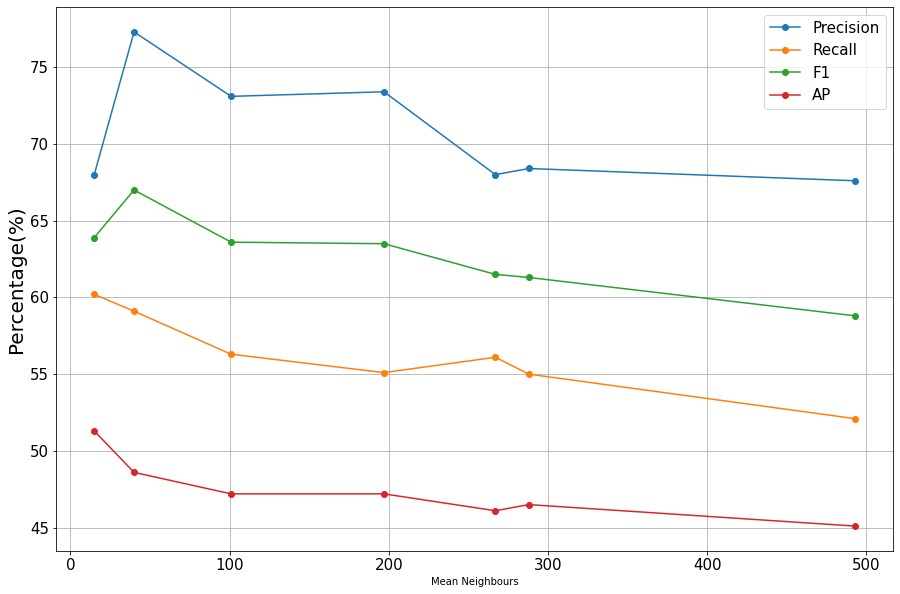

In [ ]:
df_m = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/results_method.csv')

df_m

df_m.plot(x='Mean Neighbours', figsize=(15,10), grid='True', fontsize=15, marker='o')
plt.legend(fontsize=15);
plt.ylabel('Percentage(%)', fontsize=20)


   Dataset  Precision  Recall    F1    AP
0   Src 6k       53.9    38.0  44.6  28.7
1   Aug 6k       58.8    47.2  52.4  37.1
2  Src 12k       66.4    55.0  61.3  46.5
3  Aug 12k       68.0    60.2  63.9  51.3
4  Src 25k       73.3    66.9  70.0  53.8
5  Aug 25k       69.4    66.0  67.0  52.8


Text(0, 0.5, 'Percentage(%)')

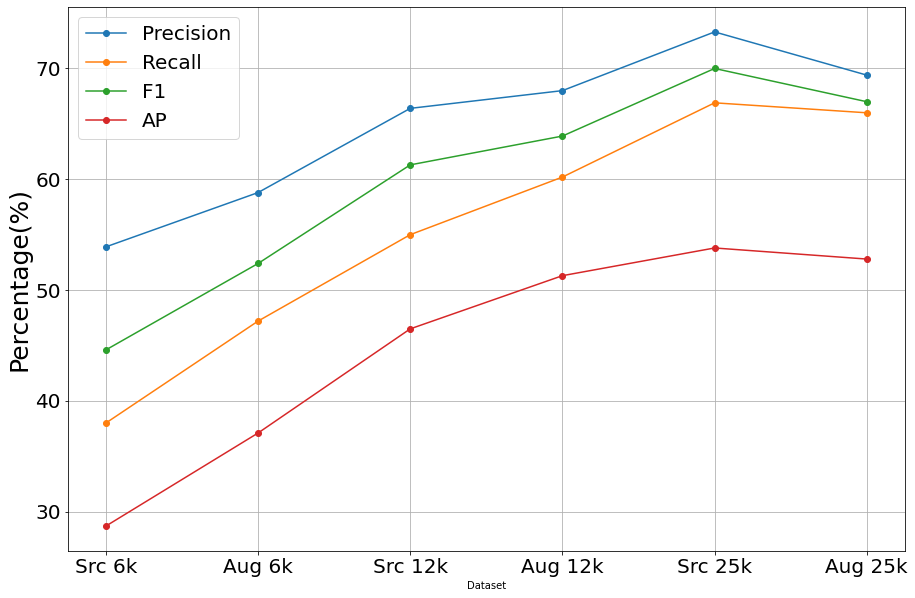

In [ ]:
df_sc = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/results_scale.csv')
df_sc[list(df_sc.columns)[1:]] = df_sc[list(df_sc.columns)[1:]]*100
print(df_sc)

df_sc.plot(x='Dataset', figsize=(15,10), grid='True', fontsize=20, marker='o')
plt.legend(fontsize=20);
plt.ylabel('Percentage(%)', fontsize=25)
#plt.plot(df_sc['Src 6k'])

Text(0, 0.5, 'Percentage(%)')

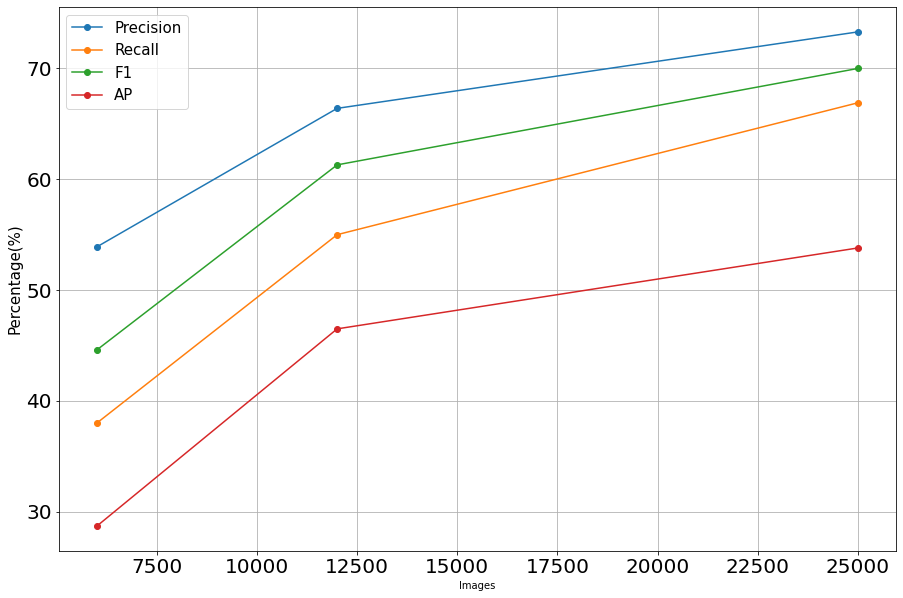

In [ ]:
df_ssrc = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/results_scale_src.csv')
df_ssrc[list(df_ssrc.columns)[2:]] = df_ssrc[list(df_ssrc.columns)[2:]]*100

df_ssrc.plot(x='Images', figsize=(15,10), grid='True', fontsize=20, marker='o')
plt.legend(fontsize=15);
plt.ylabel('Percentage(%)', fontsize=15)

Text(0, 0.5, 'Percentage(%)')

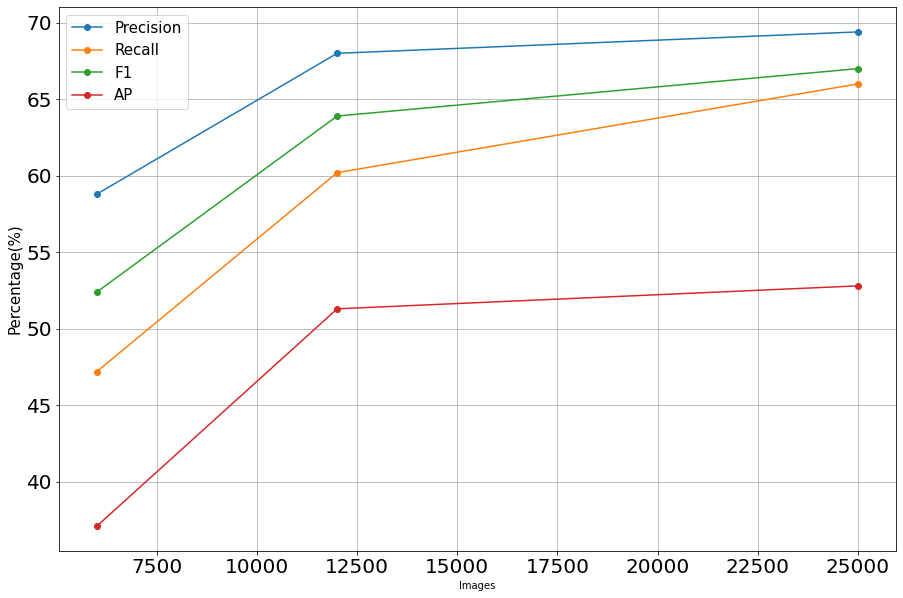

In [ ]:
df_saug = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/results_scale_aug.csv')
df_saug[list(df_saug.columns)[2:]] = df_saug[list(df_saug.columns)[2:]]*100

df_saug.plot(x='Images', figsize=(15,10), grid='True', fontsize=20, marker='o')
plt.legend(fontsize=15);
plt.ylabel('Percentage(%)', fontsize=15)

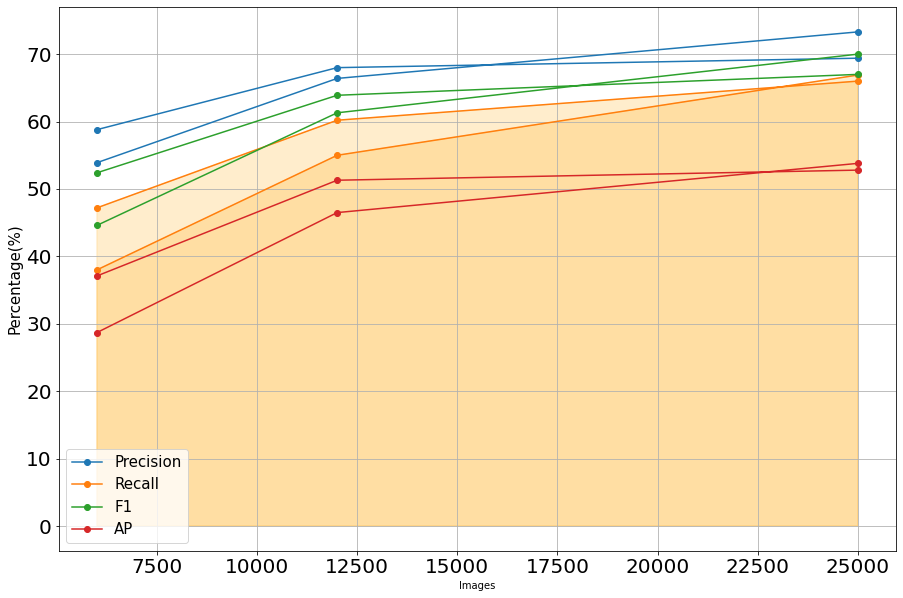

In [ ]:
df = pd.concat((df_ssrc, df_saug),axis=0)
df.dropna().reset_index(drop=True)
df.plot(x='Images', figsize=(15,10), grid='True', fontsize=20, marker='o')
plt.legend(fontsize=15);
plt.ylabel('Percentage(%)', fontsize=15)

plt.fill_between(df['Images'],df['Recall'], interpolate=True, color='orange', alpha=0.2)

In [ ]:
df_n.columns[2:-1]

Index(['Precision', 'Recall', 'F1', 'AP'], dtype='object')

In [ ]:
kp_exp = kp_ip_fil + 150

In [ ]:
# plot keypoints src
kpsrc = (kp.drop(columns=['names'])).to_numpy()

for i in range(len(kpsrc[:5])):
  print(i)
  name = "/content/" + "drive/MyDrive/surreal/play/for_report/kp_plots/src/" + src_names[i].split("/")[-1][:-4] + ".png"
  plot_kp(kpsrc[i], name)

In [ ]:
# plot keypoints tgt
kp_exp = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/kp/kp_tgt.csv')
kp_exp = (kp_exp.drop(columns=['names'])).to_numpy()
kp_exp = kp_exp[540:548]

for i in range(len(kp_exp)):
  print(i)
  name = "/content/" + "drive/MyDrive/surreal/play/for_report/kp_plots/tgt/" + str(i) + ".png"
  plot_kp(kp_exp[i], name)

In [ ]:
#Lots of saves and make_pairs
n_tgt=1000
names = "/content/content/frames/" + src_names.str.split('/',expand=True)[7]
df_pairs = create_pairs(names[:250], n_tgt)
df_pairs.to_csv('/content/drive/MyDrive/surreal/play/for_report/' + 'pairs_list.csv', index = False)

#save bbox src
df_bbox_src = kp2bbox(kp)
df_bbox_src = clip(df_bbox_src, xmax = 320, ymax = 240)
df_bbox_src['names'] = names
df_bbox_src.to_csv('/content/drive/MyDrive/surreal/play/for_report/bbox/' + 'bbox_src.csv', index=False)


#save kp_tgt
df_kp_tgt = pd.DataFrame(kp_exp)
df_kp_tgt['names'] = df_pairs['names_tgt']
df_kp_tgt.to_csv('/content/drive/MyDrive/surreal/play/for_report/kp/' + 'kp_tgt.csv', index=False)

#save bbox_tgt
df_bbox_tgt = kp2bbox(kp_exp)
df_bbox_tgt = clip(df_bbox_tgt, xmax = 320, ymax = 240)
df_bbox_tgt['names'] = df_pairs['names_tgt']
df_bbox_tgt.to_csv('/content/drive/MyDrive/surreal/play/for_report/bbox/' + 'bbox_tgt.csv', index=False)


In [ ]:
bboxs_src = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/bbox/bbox_src.csv')
pair = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/pairs_list.csv')
kp_src = pd.read_csv('/content/drive/MyDrive/surreal/play/for_report/kp/kp_src.csv')
bboxs_src.loc[bboxs_src['names']==pair.iloc[0]['names_src'].rsplit('/')[-1]].drop(columns = ["names"])
#kp_src.loc[kp_src['names'].str.split('/',expand=True)[7]==pair.iloc[0][].split('/',expand=True)[4]].drop(columns = ["names"])

,xmin,ymin,xmax,ymax


In [ ]:
#bboxs_src['names'].str.split('/', expand=True)[4]
bboxs_src['names'].str.split('/', expand=True)[4]==pair.iloc[0]['names_src'].rsplit('/')[-1]
#pair.iloc[0]['names_src'].rsplit('/')[-1]

0       True
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: 4, Length: 1000, dtype: bool

In [ ]:
print(u'H\u2082O\u2082')

H₂O₂


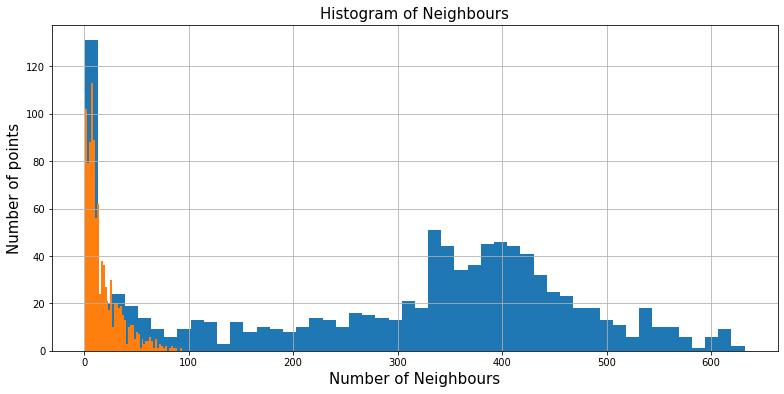

In [ ]:
plt.rcParams["figure.figsize"] = (13,6)
n, bins, patches = plt.hist(n_occ_src, bins=50, label='Augmented', align='mid')
n2, bins2, patches2 = plt.hist(n_occ_ip_fil, bins=50, label='Source')
plt.xlabel('Number of Neighbours', fontsize='15')
plt.ylabel('Number of points', fontsize='15')
plt.title('Histogram of Neighbours', fontsize='15')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()


In [ ]:
n_occ_ip_fil.shape

(1000,)